In [1]:
import tikzmagic
%load_ext tikzmagic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import matplotlib
%matplotlib inline

import scipy.signal

from ipywidgets import interact
from IPython.display import HTML, display

matplotlib.rcParams['figure.figsize'] = (8,3)
matplotlib.rcParams['animation.writer'] = 'avconv'

arrow_kwargs = {'arrowprops':dict(arrowstyle="<->",
                            )}
# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

The tikzmagic module is not an IPython extension.


# The Schmidl & Cox Synchronization Technique for OFDM
> tl;dr: Given some received OFDM signal like the following, how can one know at which point in time the OFDM symbols are located? Or, equivalently, on which signal part the receiver needs to perform the FFT?

In [2]:
# This cell can only be run once the rest of the notebook has been run (as ofdm and createFrame need to be defined)
S = np.hstack([createFrame(ofdm) for _ in range(5)]).real
plt.plot(S)
plt.grid(True); plt.xlabel('Time $t$'); plt.ylabel('$x(t)$'); plt.xlim((0, len(S)));
plt.text(len(S)/2, 0, "Where is the OFDM symbol?", va='center', ha='center', fontsize=20, color='red');

NameError: name 'createFrame' is not defined

In the [OFDM example](http://dspillustrations.com/pages/posts/misc/python-ofdm-example.html), we have described the OFDM modulation and demodulation, including channel estimation and CP insertion. On the significance of the CP we have already elaborated in [another article](http://dspillustrations.com/pages/posts/misc/the-cyclic-prefix-cp-in-ofdm.html). However, in all these works, we have assumed that the receiver knows, at which point in time the OFDM symbol is received and hence on which received samples to perform the FFT. 

However, in reality this information is not available by default. Instead, the receiver needs to perform a synchronization procedure to obtain the start of the OFDM symbol. When talking about OFDM, the most fundamental work was published by Timothy Schmidl and Donald Cox in their paper [Robust Frequency and Timing Synchronization for OFDM](http://home.mit.bme.hu/~kollar/papers/Schmidl2.pdf). In this notebook, we are going to illustrate their algorithm presented in this paper concerning the estimation of the frame start in the time domain. In addition, the authors propose a method for frequency offset estimation, which we silently ignore in the present description.

So, to summarize, here's the task of synchronization:
> Given a received OFDM signal, how can we obtain knowledge about where in the signal the OFDM symbols are located?

In what follows we will describe the proposal by Schmidl&Cox and implement this algorithm for timing synchronization. However, before we dive into the implementation, we need to setup the system model. 

## System Model and Frame Structure

Mathematically, in this notebook we describe the received signal $r(t)$ by a delayed and noisy version of the transmitted signal $x(t)$:

$$ r(t) = x(t-\tau)+n(t)$$

where $\tau$ is the delay and $n(t)$ is AWGN. $\tau$ is unknown at the receiver and needs to be estimated. 

Schmidl and Cox propose a synchronization algorithm that bases on an OFDM symbol that has a special structure. In particular, the special symbol, denoted as the *preamble*, consists of two repeated parts, prepended by a cyclic prefix (CP). As such, in this notebook, we will employ the following overall frame structure:

In [4]:
# %%tikz -l positioning,arrows,decorations.pathreplacing --size 800,300
# \draw (0,0) rectangle +(1,0.4) node [midway] {A};
# \draw (1,0) rectangle +(1,0.4) node [midway] {A};
# \draw (-0.2,0) rectangle +(0.2,0.4) node [midway] {\rotatebox{90}{\tiny{CP}}};

# \foreach \i in {0,...,3} {
#   \draw (2+\i*2.2,0) rectangle +(0.2,0.4) node [midway] {\rotatebox{90}{\tiny{CP}}};
#   \draw (2.2+\i*2.2,0) rectangle +(2,0.4) node [midway] {Payload};
# }

# \draw [decorate, decoration={brace,amplitude=5pt,mirror}] (-0.2,-0.2) -- +(2.2,0) node [midway,below,yshift=-5pt] {Preamble};
# \draw [decorate, decoration={brace,amplitude=5pt,mirror}] (2,-0.2) -- +(4*2.2,0) node [midway,below,yshift=-5pt] {N OFDM Symbols};

Each frame starts with a preamble which consists of two repeated parts, denoted by $A$. Subsequently, there will be $N$ OFDM symbols following containing the payload information. Note that in the Schmidl and Cox proposal, also the preamble can contain information, as the part $A$ can be arbitrary. The only criterion is that the part is repeated twice.

## Modeling the received signal
To implement the synchronization algorithm, let us first generate an appropriate receive signal. We start with a dummy structure which holds all the OFDM parameters:

In [5]:
class OFDM:
    pass
ofdm = OFDM()
ofdm.K = 1024                      # Number of OFDM subcarriers
ofdm.Kon = 600                     # Number of switched-on subcarriers
ofdm.CP = 128                      # Number of samples in the CP
ofdm.ofdmSymbolsPerFrame = 5       # N, number of payload symbols in each frame
ofdm.L = ofdm.K//2                 # Parameter L, denotes the length of one repeated part of the preamble

Moreover, let's define a function for generating random QAM symbols:

In [6]:
def random_qam(ofdm):
    qam = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    return np.random.choice(qam, size=(ofdm.Kon), replace=True)

Now, we define a function to perform OFDM modulation and CP insertion:

In [7]:
def ofdm_modulate(ofdm, qam):
    assert (len(qam) == ofdm.Kon)
    fd_data = np.zeros(ofdm.K, dtype=complex)
    off = (ofdm.K - ofdm.Kon)//2
    fd_data[off:(off+len(qam))] = qam  # modulate in the center of the frequency
    fd_data = np.fft.fftshift(fd_data)
    symbol = np.fft.ifft(fd_data) * np.sqrt(ofdm.K)
    return np.hstack([symbol[-ofdm.CP:], symbol])

Now, let's generate an example preamble. To generate two repetitive parts, we exploit a [property of the Fourier Transform](http://dspillustrations.com/pages/posts/misc/the-dirac-comb-and-its-fourier-transform.html): The DFT of a $P$-periodic sequence (i.e. a sequence consisting of $P$ repetions on one part), is non-zero only every $P$th sample. Hence, if we create a frequency domain signal with every other sample zero, the corresponding time-domain signal is 2-periodic:

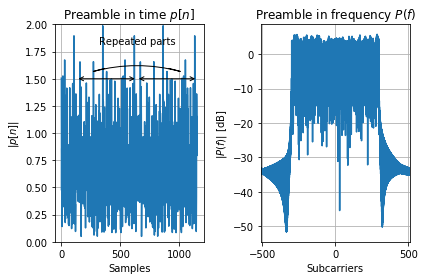

In [8]:
qam_preamble = np.sqrt(2)*random_qam(ofdm)
qam_preamble[::2] = 0   # delete every second data to make the preamble 2-periodic

preamble = ofdm_modulate(ofdm, qam_preamble)

plt.subplot(121)
plt.plot(abs(preamble))
plt.grid(True); plt.xlabel('Samples'); plt.ylabel('$|p[n]|$'); plt.title('Preamble in time $p[n]$');
plt.annotate(s='', xy=(ofdm.CP,1.5), xytext=(ofdm.L+ofdm.CP,1.5), arrowprops=dict(arrowstyle='<->'));
plt.annotate(s='', xy=(ofdm.L+ofdm.CP,1.5), xytext=(2*ofdm.L+ofdm.CP,1.5), arrowprops=dict(arrowstyle='<->'));
plt.annotate(s='', xy=(ofdm.L/2+ofdm.CP,1.6),
             xytext=(1.5*ofdm.L+ofdm.CP,1.6),
             arrowprops=dict(
                 arrowstyle='-',
                 connectionstyle='angle,angleA=-15,angleB=15,rad=45'))
plt.text(ofdm.CP+ofdm.L, 1.8, 'Repeated parts', va='bottom', ha='center', fontsize=10);
plt.ylim((0,2))

plt.subplot(122)
f = np.linspace(-ofdm.K/2, ofdm.K/2, 4*len(preamble), endpoint=False)
plt.plot(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(preamble, 4*len(preamble))/np.sqrt(len(preamble))))))
plt.grid(True); plt.xlabel('Subcarriers'); plt.ylabel('$|P(f)|$ [dB]'); plt.title('Preamble in frequency $P(f)$');
plt.xlim((-ofdm.K/2, ofdm.K/2))
plt.tight_layout();

Now, that we can create a preamble, let's write a function that creates one frame according to the structure defined earlier:

In [9]:
def createFrame(ofdm, qam_preamble=None):
    if qam_preamble is None:
        qam_preamble = np.sqrt(2)*random_qam(ofdm)
        qam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, qam_preamble)
    
    payload = np.hstack([ofdm_modulate(ofdm, random_qam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    return np.hstack([preamble, payload])

Let's plot the frame and annotate the symbol. For letting the preamble shine out, we amplify it a bit:

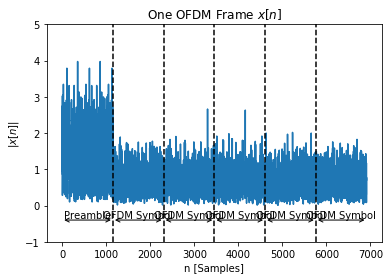

In [10]:
frame = createFrame(ofdm, qam_preamble=qam_preamble*2)
plt.plot(abs(frame))
plt.ylim((-1, 5))
symLength = ofdm.K + ofdm.CP
plt.annotate(s='',xy=(0,-0.4), xytext=(symLength, -0.4), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5*(ofdm.K+ofdm.CP),-0.4,r'Preamble',va='bottom', ha='center', fontsize=10);
for s in range(ofdm.ofdmSymbolsPerFrame):
    plt.annotate(s='',xy=((s+1)*symLength, -0.4), xytext=((s+2)*symLength, -0.4), arrowprops=dict(arrowstyle='<->'))
    plt.text((s+1.5)*symLength, -0.4, 'OFDM Symbol', va='bottom', ha='center', fontsize=10);
    plt.axvline((s+1)*symLength, ls='dashed', color='black')
plt.xlabel('n [Samples]'); plt.ylabel('$|x[n]|$'); plt.title('One OFDM Frame $x[n]$');

Now, let's define the channel, which we model with some functions:

In [11]:
def addCFO(signal, cfo):  # Add carrier frequency offset (unused in this notebook)
    return signal * np.exp(2j*np.pi*cfo*np.arange(len(signal)))

def addSTO(signal, sto):  # add some time offset
    return np.hstack([np.zeros(sto), signal])

def addNoise(signal, sigma2):  # add AWGN
    noise = np.sqrt(sigma2/2) * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return signal + noise

def addChannel(signal, h):       # add some multipath impulse response (unused in this notebook)
    return scipy.signal.lfilter(h, (1,), signal)

We can try out these functions in the following:

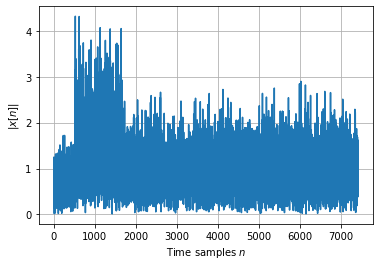

In [12]:
x = createFrame(ofdm, qam_preamble=qam_preamble*2)
sto = ofdm.K//2
r = addNoise(addSTO(x, sto), 0.5)
plt.plot(abs(r));
plt.xlabel('Time samples $n$'); plt.ylabel('$|x[n]|$'); plt.grid(True);

Now that we can create a receive signal, we can implement the proposed synchronization algorithm. The algorithm is based on a metric which is calculated from the received signal. In short, when the metric goes beyond a certain threshold, the preamble is detected.

### Calculating $P(d)$
In their paper, the authors propose the following metric $P(d)$ given by equation (5) as

$$ P(d) = \sum_{m=0}^{L-1}(r[d+m]^*r[d+m+L]) $$

which we can calculate directly:

In [ ]:
# Method 1 to calculate P(d)
d_set = np.arange(0, sto + ofdm.K)
P1 = np.zeros(len(d_set), dtype=complex)
for i, d in enumerate(d_set):
    P1[i] = sum(r[d+m].conj()*r[d+m+ofdm.L] for m in range(ofdm.L))           

In [ ]:
plt.plot(d_set, abs(P1))
plt.grid(True); plt.xlabel('$d$'); plt.ylabel('$|P(d)|$'); plt.ylim((-10, 4*350));
plt.annotate(s='', xy=(sto, 4*310), xytext=(sto+ofdm.CP,4*310), arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
plt.text(sto+0.5*ofdm.CP,4*310,r'CP',va='bottom', ha='center', fontsize=10);
plt.axvline(sto, color='black', ls='dotted')
plt.axvline(sto+ofdm.CP, color='black', ls='dotted');

plt.annotate(s='', xy=(0, 4*310), xytext=(sto,4*310), arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
plt.text(0.5*sto, 4*310, 'Timing offset', va='bottom', ha='center', fontsize=10);

As we see, the metric $P(d)$ shows a plateau starting at the timing offset. Moreover, the plateau has the width equal to the CP length. With this observation, it might be problematic to determine the exact start of the OFDM frame as no distinct peak occurs. However, by using the CP we explicitely allow to overcome slight timing offsets and subsequent channel estimation will recover the residual timing offset. 

As an alternative calculation, Schmidl and Cox give a recursive method to calculate $P(d)$ by

$$ P(d+1) = P(d) + r[d+L]^*r[d+2L] - r[d]^*r[d+L] $$

which we can also implement directly. However, note that the starting point $P(0)$ still needs to be calculated in the standard way. Let's first check if both ways to calculate the metric are equal:

In [ ]:
# Method 2 to calculate P(d)
P0 = sum(r[m].conj()*r[m+ofdm.L] for m in range(ofdm.L))  # initialize P[0] with the default method
def calcP_method2(r, d_set, P0):
    P2 = np.zeros(len(d_set), dtype=complex)
    P2[0] = P0
    for d in d_set[:-1]:
        P2[d+1] = P2[d] + r[d+ofdm.L].conj()*r[d+2*ofdm.L] - r[d].conj()*r[d+ofdm.L]
    return P2

P2 = calcP_method2(r, d_set, P0)

plt.plot(d_set, abs(P2), 'b--', lw=3, label='$P(d)$ (equation (6))'); 
plt.plot(d_set, abs(P1), 'r', label='$P(d)$ (equation (5))')
plt.legend(); plt.grid(True); plt.xlabel('$d$'); plt.ylabel('$|P(d)|$'); plt.ylim(-10, 4*350);

Unsurprisingly, both methods yield the same result. Let's see, what happens, if we set the initial condition to $P(0)=0$ to overcome the initial calculation of $P(0)$:

In [ ]:
P2_0 = calcP_method2(r, d_set, P0=0)
plt.plot(d_set, abs(P2_0), 'b--', lw=3, label='$P(d)$ (equation (6) with $P(0)=0$)'); 
plt.plot(d_set, abs(P1), 'r', label='$P(d)$ (equation (5))')
plt.legend(); plt.grid(True); plt.xlabel('$d$'); plt.ylabel('$|P(d)|$'); plt.ylim((-10, 4*350));

The curve marginally changes, however the general shape remains the same. To further formalize the calculation of $P(d)$ let us define the following signal $v[d]$ by

$$ v[d] = r[d+L]^*r[d+2L]$$

With this definition, we can rewrite the recursive calculation of $P(d)$ as

$$ P(d+1) = P(d) + v[d] - v[d-L], $$

which seemingly becomes a linear IIR filtering operation of $v[d]$. However, note that, unfortunately, $v[d]$ is not causal, as it depends on data from the future, namely on $r[d+L]$ and $r[d+2L]$. To make the system causal, we can introduce an artificial delay of $2L$ samples to $r[d]$ to yield $\bar{r}[n]=r[n-2L]$. Now, defining 

$$ \bar{v}[d] = \bar{r}[d+L]^*\bar{r}[d+2L]=r[d-L]^*r[d]$$

we can find a causal version $\bar{P}(d)$ by

$$ \bar{P}(d+1) = \bar{P}(d) + \bar{v}[d] - \bar{v}[d-L] $$

which we can calculate by a standard IIR filter implementation:

In [ ]:
def calcP_method3(r):
    L = ofdm.L
    b_P = np.zeros(L)
    b_P[0] = 1; b_P[L-1] = -1;
    a_P = (1, -1)
    
    # Implements r[d-L] * r[d], assuming r[d<0] = 0
    v_bar = np.hstack([np.zeros(L), r[L:].conj() * r[:-L]]) 
    P_bar = scipy.signal.lfilter(b_P, a_P, v_bar)
    return P_bar

P_bar = calcP_method3(r)
plt.plot(abs(P_bar), label='$\\bar{P}(d)$')
plt.plot(abs(P1), label='$P(d)$')
plt.grid(True); plt.xlim((0, 3000)); plt.xlabel('$d$'); plt.ylabel('$|P(d)|$'); plt.legend(); plt.ylim((-10, 4*350));
plt.annotate(s='', xy=(sto,4*310), xytext=(sto+2*ofdm.L,4*310), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0));
plt.text(sto+ofdm.L, 4*310, '$2L$ Filter Delay', va='bottom', ha='center', fontsize=10);

Apparently, the filter has a delay of $2L$ samples compared to the non-causal (and hence not realizable) original implementation. Now, given that we have a linear IIR filter, it might be interesting to look at its impulse response:

In [ ]:
b = np.zeros(ofdm.L); b[0] = 1; b[ofdm.L-1] = -1;
a = (1,-1)
impulse = np.zeros(4*ofdm.L); impulse[500] = 1;

plt.plot(np.arange(len(impulse)), scipy.signal.lfilter(b, a, impulse))
plt.ylim((-0.1,1.1)); plt.grid(True); plt.xlabel('Samples'); plt.ylabel('$h[n]$'); plt.title('Response to $v[n]=\\delta[n-500]$');

The impulse response of the filter is a rect function of width of $L$ samples. This makes sense, looking at equation (5) in the original paper. But wait, ... didn't we just say we have an IIR (infinite impulse response) filter? Hm, let's have a look in more detail into the Z domain of the filter. Here, we simplify a bit and use the common $x[n]$ and $y[n]$ for input and output signals, respectively:

$$\begin{align} y[n] &= y[n-1] + x[n] - x[n-L] \\
Y(z)(1-z^{-1})&=X(z)(1-z^{-L})\\
H(z)&=\frac{Y(z)}{X(z)}=\frac{1-z^{-L}}{1-z^{-1}}\\
&=\frac{(1-z^{-1})(1+z^{-1}+z^{-2}+\dots+z^{-(L-1)}}{1-z^{-1}}=1+z^{-1}+z^{-2}+\dots+z^{-(L-1)}\end{align}$$

There, the last rows follows from the general rule $1-x^{-n}=(1-x)(1+x^{-1}+\dots+x^{-(n-1)})$. Hence, we see that the pole and zero at $z=1$ cancel out and hence leaves us with a FIR filter, which can still be implemented recursively. 

### Calculating $R(d)$

In addition to the autocorrelation metric $P(d)$, Schmidl and Cox propose to employ the receive energy $R(d)$ given by

$$R(d) = \sum_{m=0}^{L-1}|r[d+m+L]|^2 $$

which can again be calculated with steps similar to $P(d)$. In particular, the non-causal recursive version is given by

$$ R(d+1) = R(d) + |r[d+2L]|^2-|r[d+L]|^2 $$

and the corresponding causal version is given by

$$ \bar{R}(d+1) = \bar{R}(d) + |r[d]|^{2} - |r[d-L]|^{2}. $$

Let us compare their implementation:

In [ ]:
def calcR_method1(r, d_set):
    # calculation based on the iterative method
    R = np.zeros(len(d_set))
    for i, d in enumerate(d_set):
        R[i] = sum(abs(r[d+m+ofdm.L])**2 for m in range(ofdm.L))
    return R

def calcR_method2(r, d_set, R0):
    # calculation based on non-causal recursive expression
    R = np.zeros(len(d_set))
    R[0] = R0
    for d in d_set[:-1]:
        R[d+1] = R[d] + abs(r[d+2*ofdm.L])**2-abs(r[d+ofdm.L])**2
    return R

def calcR_method3(r):
    # calculation based on IIR filter expression
    b = np.zeros(ofdm.L); b[0] = 1; b[-1] = -1;
    a = (1,-1)
    return scipy.signal.lfilter(b, a, abs(r)**2)

R1 = calcR_method1(r, d_set)
R2 = calcR_method2(r, d_set, R1[0])
R_bar = calcR_method3(r)

In [ ]:
plt.plot(abs(R1), 'b--', lw=3, label='R, method 1')
plt.plot(abs(R2), 'r', label='R, method 2')
plt.plot(abs(R_bar), 'g', label='R, method 3')
plt.grid(True); plt.xlabel('$d$'); plt.ylabel('$|R(d)|$'); plt.xlim((0, 3000)); plt.legend()
plt.annotate(s='', xy=(0,4*270), xytext=(2*ofdm.L,4*270), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0));
plt.text(ofdm.L, 4*270, '$2L$ Filter Delay', va='bottom', ha='center', fontsize=10);

### Calculating the final metric $M(d)$

Finally, the authors propose to normalize the autocorrelation $P(d)$ with the receive energy $R(d)$, yielding the final metric $M(d)$ given by

$$ M(d) = \frac{|P(d)|^2}{R(d)^2}. $$

Let's look at this metric for our frame:

In [ ]:
import matplotlib.patches as patches

M = abs(P1)**2/R1**2
M_bar = abs(P_bar)**2/R_bar**2

plt.plot(abs(r), label='$r[n]$', color='cyan')
plt.plot(M, label='$M(d)$')
plt.plot(M_bar, label='$\\bar{M}(d)$')
plt.grid(True); plt.legend(); plt.xlim(0, 5000);

symLength = ofdm.K + ofdm.CP
plt.annotate(s='',xy=(sto, 4), xytext=(sto+symLength, 4), arrowprops=dict(arrowstyle='<->'))
plt.text(sto+0.5*(ofdm.K+ofdm.CP),4,r'Preamble',va='bottom', ha='center', fontsize=10);
plt.axvline(sto, color='black', ls='--'); plt.axvline(sto+symLength, color='black', ls='--');

plt.annotate(s='', xy=(sto,1), xytext=(sto+2*ofdm.L,1), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0));
plt.text(sto+1.2*ofdm.L, 1, '$2L$ Filter Delay', va='bottom', ha='center', fontsize=10);
plt.gca().add_patch(patches.Rectangle((sto,0), ofdm.CP, 5, hatch='/', fill=None, zorder=100,color='gray'));
plt.text(sto+ofdm.CP/1.5, 2.5, 'Cyclic prefix', rotation=90, va='center', ha='center');

As shown, the original $M(d)$ reaches the maximum, when the preamble starts. However, this filter is non-causal, as it requires knowledge of the upcoming samples from the signal. The causal version $\bar{M}(d)$ has a delay of 2L samples but is practically realizable. 

### Evaluation of the metric magnitude

In their paper, the authors derive that the metric $M(d)$ evaluated at the correct timing (i.e. within the CP of the preamble) is Gaussian distributed, with mean $\mu$ and variance $\sigma^2$, which are given by

$$\begin{align} \mu &= \frac{\sigma_s^4}{(\sigma_s^2+\sigma_n^2)^2} & \text{equation (19)}\\
\sigma^2 &= \frac{2\sigma_s^4[(1+\mu)\sigma_s^2\sigma_n^2+(1+2\mu)\sigma_n^4]}{L(\sigma_s^2+\sigma_n^2)^4}&\text{equation (20)}
\end{align}$$

where $\sigma_s^2$ is the preamble power and $\sigma_n^2$ is the noise power. With the relation of the SNR $\rho$ given by
$$ \rho=\frac{\sigma_s^2}{\sigma_n^2}, \quad \sigma_n^2=\rho\sigma_s^2$$ we find these two equations to become

$$ \begin{align}\mu &= \frac{1}{(1+\rho)^2}\\ \sigma^2 &= \frac{2[(1+\mu)\rho+(1+2\mu)\rho^2]}{L(1+\rho)^4} \end{align}.$$

Let us verify this numerically. First, let's define a common function that calculates our metric $\bar{M}$. However, we already erase the first $L$ samples, as they contain largely garbage information:

In [ ]:
def calcP_R_M(rx_signal, L):
    rx1 = rx_signal[:-L]
    rx2 = rx_signal[L:]
    mult = rx1.conj() * rx2
    square = abs(rx1**2)
    
    zi = np.zeros(L-1)
    
    a_P = (1, -1)
    b_P = np.zeros(L); b_P[0] = 1; b_P[-1] = -1;
    P = scipy.signal.lfilter(b_P, a_P, mult) / L
    R = scipy.signal.lfilter(b_P, a_P, square) / L
    
    Pr = P[L:]
    Rr = R[L:]
    M = abs(Pr/Rr)**2
    return Pr, Rr, M  # throw away first L samples, as they are not correct due to filter causality

Now, let's calculate the metric for different SNRs:

In [ ]:
from collections import defaultdict
# Careful, this cell takes some time to run
M_dopt = defaultdict(list)
M_doutside = defaultdict(list)
SNRs = np.linspace(-10, 30, 21)
for SNR in SNRs:
    for i in range(100):
        tx_signal = createFrame(ofdm, qam_preamble=None)
        sigma_s2 = np.mean(abs(tx_signal**2))
        sigma_n2 = sigma_s2 * 10**(-SNR/10.)
        sto = 1000
        cfo = 0.05/ofdm.K
        rx_signal = addNoise(addCFO(addSTO(tx_signal, sto), cfo), sigma_n2)
        P, R, M = calcP_R_M(rx_signal, ofdm.L)
        M_dopt[SNR].append(M[sto])
        M_doutside[SNR].append(M[sto+ofdm.K])

Finally, let's evaluate the results and compare against the theoretic values:

In [ ]:
def calc_MeanStd(SNRs, measurement):
    mean = np.array([np.mean(measurement[SNR]) for SNR in SNRs])
    std = np.array([np.std(measurement[SNR]) for SNR in SNRs])
    return mean, std
mean_opt, std_opt = calc_MeanStd(SNRs, M_dopt)

# Plot the measured curves
plt.plot(SNRs, mean_opt, label='Simulated', color='blue', lw=3)
plt.plot(SNRs, mean_opt+3*std_opt, 'b--')
plt.plot(SNRs, mean_opt-3*std_opt, 'b--')

# Plot the theoretic curves
rho = 10**(-SNRs/10)
mu = 1/(1+rho)**2
std = np.sqrt(2*((1+mu)*rho+(1+2*mu)*rho**2)/(ofdm.L*(1+rho)**4))
#print (std)
plt.plot(SNRs, mu, label='Theory', color='r', lw=2)
plt.plot(SNRs, mu + 3*std, color='r', lw=2, ls='--')
plt.plot(SNRs, mu - 3*std, color='r', lw=2, ls='--')
plt.grid(True); plt.legend(); plt.xlabel('SNR [dB]'); plt.ylabel('$M(d_{opt})$'); plt.ylim((0,1));

Apparently, the simulated and theoretic curves overlap. Moreover, the values coincide with Fig. 4 from the original reference. 

### Using $M(d)$ for synchronization

Given the metric $M(d)$, it still remains unclear how the metric shall be practically used for timing synchronization. We will explain this is the following. Intuitively, it's clear that whenever $M(d)$ goes beyond a certain threshold, a preamble was detected. However, given that the metric does not have a clear peak, but a plateau, some extra logic is necessary to detect the actual frames. 

Consider a frame structure as previously. In addition, there can be arbitrary delay between frames to make timing synchronization more difficult. Let's first create a sample signal. For illustration purposes we also indicate where the preamble and where the payload symbols are located:

In [ ]:
def createFrame_withSyncInfo(ofdm):
    qam_preamble = np.sqrt(2)*random_qam(ofdm)
    qam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, qam_preamble)

    payload = np.hstack([ofdm_modulate(ofdm, random_qam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    
    frame = np.hstack([preamble, payload])
    preamble_valid = np.zeros(len(frame))
    payload_valid = np.zeros(len(frame))
    preamble_valid[ofdm.CP:ofdm.CP+ofdm.K] = 1
    for f in range(ofdm.ofdmSymbolsPerFrame):
        payload_valid[(ofdm.CP+ofdm.K)*(f+1) + ofdm.CP + np.arange(ofdm.K)] = 1
    
    return frame, preamble_valid, payload_valid
frame, preamble_valid, payload_valid = createFrame_withSyncInfo(ofdm)
plt.plot(abs(frame), label='Signal');
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.grid(True); plt.ylim((-0.5, 2))
symLength = ofdm.K + ofdm.CP
plt.annotate(s='',xy=(0,-0.4), xytext=(symLength, -0.4), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5*(ofdm.K+ofdm.CP),-0.4,r'Preamble',va='bottom', ha='center', fontsize=10);
for s in range(ofdm.ofdmSymbolsPerFrame):
    plt.annotate(s='',xy=((s+1)*symLength, -0.4), xytext=((s+2)*symLength, -0.4), arrowprops=dict(arrowstyle='<->'))
    plt.text((s+1.5)*symLength, -0.4, 'Payload', va='bottom', ha='center', fontsize=10);
    plt.axvline((s+1)*symLength, ls='dashed', color='black')
plt.xlabel('n [Samples]'); plt.ylabel('$|x[n]|$'); plt.title('One OFDM Frame $x[n]$');
plt.legend(fontsize=9);

Now, let's create a signal consisting of 3 frames with some delays between them. We plot the signal and the corresponding genie-sync information. 

In [ ]:
np.random.seed(14);
delays = [1000, 1500, 2000]
tx_signal = []
preamble_valid = []
payload_valid = []
for d in delays:
    Z = np.zeros(d)
    frame, pream_valid, pay_valid = createFrame_withSyncInfo(ofdm)
    tx_signal.extend([frame, Z]); preamble_valid.extend([pream_valid, Z]); payload_valid.extend([pay_valid, Z])
tx_signal = np.hstack(tx_signal); preamble_valid = np.hstack(preamble_valid); payload_valid = np.hstack(payload_valid)

rx_signal = addNoise(addSTO(tx_signal, sto), 0.5)
preamble_valid = addSTO(preamble_valid, sto)
payload_valid = addSTO(payload_valid, sto)
plt.plot(abs(rx_signal), color='cyan', label='RX signal');
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$|x[n]|$'); plt.legend(fontsize=10); plt.xlim((0, len(rx_signal)));

Now, the task is to write a function that recreates the sync-info solely based on the received signal. To start out, let's calculate the our metric and plot it on top of the preamble_valid metric.

In [ ]:
P, R, M = calcP_R_M(rx_signal, ofdm.L)
plt.subplot(211)
plt.plot(abs(rx_signal), label='Rx signal', color='cyan')
plt.plot(abs(M), label='M')
plt.plot(preamble_valid, label='Genie Preamble valid')
plt.legend(fontsize=10);
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$|x[n]|, M(n)$'); plt.legend(fontsize=10);
plt.yticks([0, 1, 2])
plt.ylim((0, 3));

plt.subplot(212)
plt.plot(abs(rx_signal), label='Rx signal', color='cyan')
plt.plot(abs(M), label='M')
plt.plot(preamble_valid, label='Genie Preamble valid')
plt.legend(fontsize=10);
plt.xlim((0, 4*ofdm.K))
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$|x[n]|, M(n)$'); plt.legend(fontsize=10);
plt.yticks([0, 1, 2])
plt.tight_layout();
plt.ylim((0, 3));

As visible in the zoomed-in version, the genie preamble-valid signal becomes true at the end of the plateau of the metric. Hence, we need to write an algorithm that detects the end of the plateau. We know, the plateau has a with of the size of the CP. One option to transform the plateau into a peak is to perform a matched filtering operation with a rectangle of the width of the plateau:

In [ ]:
b_toPeak = np.ones(ofdm.CP) / ofdm.CP
a = (1,)
M_filt = scipy.signal.lfilter(b_toPeak, a, M)
xlim = (0, 20000)

preamble_start = np.diff(preamble_valid) == 1  # Calculate a flag indicating the start of the preamble

plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(M, label='$M$')
plt.plot(M_filt, label='$M * rect(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.xlabel('$n$'); plt.ylabel('$M(n)$'); plt.grid(True); plt.legend(fontsize=10);

plt.subplot(312)
plt.plot(M, label='$M$')
plt.plot(M_filt, label='$M * rect(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.xlim((400, 1400)); plt.ylim((0,0.4));
plt.xlabel('$n$'); plt.ylabel('$M(n)$'); plt.grid(True); plt.legend(fontsize=10, loc='best');

As shown, the filtering with a rectangle as two effects: First, it smooths out some noise, second it transforms the plateau into a peak, though the peak is not very pronounced. Let us now try to perform some peak detection on the green line. As known, a peak in a curve corresponds to a zero in its derivative. So, let's look at the derivative:

In [ ]:
D = np.diff(M_filt)
plt.plot(D, label='Derivative of $M*rect(CP)$')
plt.plot(preamble_start, label='Preamble start', color='r')
plt.ylim((-0.002,0.002)); plt.grid(True); plt.legend(fontsize=10);

This looks good already! The derivative seems to have zeros where the preamble starts. Let's further investigate and detect the zero-crossings of the derivative. The zero-crossings of a signal are determined by a sign change of adjacent samples, hence the product of two adjacent samples should be negative:

In [ ]:
zeroCrossing_1 = (D[:-1] * D[1:]) <= 0
plt.plot(zeroCrossing_1, label='Detected Zero-Crossings (1)');
plt.plot(preamble_start, label='Preamble start');
plt.grid(True); plt.legend(fontsize=10); plt.ylim((-0.1, 1.1));

Hm, there are a lot of erroneous zero-crossings detected. Sure, when the metric is small (i.e. there is no preamble), there is only noise on the preamble, and there a lot of zero-crossings happen. So, let's add another criterion: Detect the zero-crossings, where the metric goes beyond a certain threshold:

In [ ]:
zeroCrossing_2 = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 0.1)
plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)');
plt.plot(preamble_start, label='Preamble start');
plt.grid(True); plt.legend(fontsize=10); plt.ylim((-0.1, 1.1));

Ah, this looks much better. But, now let's zoom into one preamble start to examine a bit more in detail how the detected zero-crossings look:

In [ ]:
zeroCrossing_2 = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 0.1)
plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)');
plt.plot(preamble_start, label='Preamble start');
plt.plot(D*1000, label='Derivative of $M*rect(CP)$');
plt.xlim((1000, 1200))
plt.grid(True); plt.legend(fontsize=10); plt.ylim((-0.3, 1.1));

Hm, there are multiple zero-crossings detected. This is clear, when looking at the derivative, as it indeed has multiple zero-crossings. Moreover, the position of the detected zero-crossings does not match exactly the expected position. Instead, the zero-crossings appear few samples before the correct starting point. However, this is not a problem as the OFDM symbol contains a CP and hence makes it robust against slight timing misalignments. 

Let's try to remove the multiple peaks and just keep the first sample. The idea is to ignore all detected zero-crossings except the first one in a range of $K+CP$ samples:

In [ ]:
# create a rect window that remains switched on as for the length of the symbol
b_ignore = np.ones(1+ofdm.K+ofdm.CP); b_ignore[0] = 0;  
ignore_times = (scipy.signal.lfilter(b_ignore, (1, ), zeroCrossing_2) > 0).astype(int)

plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)');
plt.plot(preamble_start, label='Preamble start');
plt.plot(D*1000, label='Derivative of $M*rect(CP)$');
plt.plot(ignore_times, label='Ignore window')
plt.xlim((1000, 1200))
plt.grid(True); plt.legend(fontsize=10); plt.ylim((-0.3, 1.1));

Now, we delete all detected zero-crossings when the ignore-window is non-zero:

In [ ]:
zeroCrossing_3 = zeroCrossing_2 * (ignore_times == 0)   # keep only the zero-crossings where the ignore-window is not on
plt.plot(zeroCrossing_3, label='Detected Zero-Crossing (3)');
plt.plot(preamble_start, label='Preamble start');
plt.plot(D*1000, label='Derivative of $M*rect(CP)$');
plt.xlim((1000, 1200))
plt.grid(True); plt.legend(fontsize=10); plt.ylim((-0.3, 1.1));

Now, we have extracted the first zero-crossing and hence extracted an estimate of the preamble start. As the final step, we need to extract the OFDM symbols and preamble from the received signal stream. Let's simply do this with a FIR filter describing the structure of the frame:

In [ ]:
b_preamble = np.zeros(ofdm.K+ofdm.ofdmSymbolsPerFrame*(ofdm.K+ofdm.CP))
b_preamble[:ofdm.K] = 1

b_payload = np.zeros(ofdm.K + ofdm.ofdmSymbolsPerFrame*(ofdm.K+ofdm.CP))
for s in range(ofdm.ofdmSymbolsPerFrame):
    b_payload[ofdm.K + (s+1)*ofdm.CP + s*ofdm.K + np.arange(ofdm.K)] = 1
    
preamble_valid_est = scipy.signal.lfilter(b_preamble, (1,), zeroCrossing_3)
payload_valid_est = scipy.signal.lfilter(b_payload, (1,), zeroCrossing_3)

plt.plot(abs(rx_signal), color='cyan', label='RX signal');
plt.plot(preamble_valid, label='Preamble valid', color='blue')
plt.plot(preamble_valid_est, label='Preamble valid estimated', color='blue', ls='--')
plt.plot(payload_valid, label='Payload valid', color='r')
plt.plot(payload_valid_est, label='Payload valid', color='r', ls='--')
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$|x[n]|$'); plt.legend(fontsize=10); plt.xlim((0, len(rx_signal)));

Great! Now, we have nicely extracted the OFDM payload symbols excluding the CP. The estimated frame position sufficiently matches the exact positions of the symbols. However, due to the CP, a slight timing offset is not problematic. 

In a subsequent step, we would send these symbols to the OFDM demodulator and channel estimator, as described in e.g. [the OFDM Example](http://dspillustrations.com/pages/posts/misc/python-ofdm-example.html).

## Summary
> 1. Synchronization in OFDM is necessary to detect the start of an OFDM frame, such that the FFT window can be located correctly.
> 2. For OFDM, the most basic algorithm is the Schmidl&Cox-Algorithm which bases on a synchronization sequence that consists of two repeated parts.
> 3. The synchronization algorithm calculates a metric which shows a plateau around the position of the preamble. 
> 4. To implement a real OFDM synchronization, additional logic for plateau detection and preamble and payload extraction is necessary after the metric has been obtained successfully.